In [1]:
import numpy as np
import sympy, scipy, cmath
from sympy import *
from sympy.mpmath import *
#from sympy import symbols
#from sympy.solvers.solveset import nonlinsolve
from scipy import sparse as sp
#from scipy import linalg as ln
from scipy import optimize as opt
from scipy.sparse import  coo_matrix as cmm
from matplotlib import pyplot as pp
from numpy import pi as pi

#mp.pretty=True
def bessel(x):
    return besselj(0,x)+1j*struveh(0,x)

In [2]:
#Parameters
#global kx,mu, m, t, alR, B, kF, a, al, delta, phi, delL, delR, nu0, tL, tR, NJ, eye2, s1, s2, s3, tP, tM, t3

mu=1.8
m=.5
t=3
alR=1.
def mut(kx):
    return mu-2*t-kx**2/(2*m)-alR**2*m/2
B=3.    #looped
kF=cmath.sqrt(2*m*mu)

a=1/cmath.sqrt(2*m*t)
al=alR/a

delta=.5
phi=1.5*np.pi
delL=delta*cmath.exp(1j*phi/2)
delR=delta*cmath.exp(-1j*phi/2)
nu0=m/(2*np.pi)
def xiE(En):
    return kF/(m*cmath.sqrt(delta**2-En**2))

tL=2
tR=tL

NJ=3

#matrix tools
eye2=np.eye(2)
eye4=np.eye(4)
s1=[[0,1],[1,0]]
s2=[[0,-1j],[1j,0]]
s3=[[1,0],[0,-1]]
tP=np.kron([[0,1],[0,0]],eye2)
tM=np.kron([[0,0],[1,0]],eye2)
t3=np.kron(s3,eye2)

In [37]:
#Junction
def HJ0(kx):
    return -mut(kx)*t3+alR*kx*np.kron(s3,s2)+B*np.kron(eye2,s1)
Hy=-t*t3+1j*al/2*np.kron(s3,s1)


def HJ(kx):
    start=cmm(HJ0(kx))
    HJs=start
    for n in range(0,NJ-1):
        OT=cmm(np.zeros([len(HJs.toarray())-4,4]))
        BT=sp.vstack([OT,cmm(Hy)])
        CT=sp.hstack([OT.transpose(),cmm(Hy.conj().T),start])
        HJs=sp.hstack([HJs,BT])
        HJs=sp.vstack([HJs,CT])
    return HJs

def gJm1(En,kx):
    return En*np.eye(4*NJ)-HJ(kx).toarray()

#Superconductors
# xiE-> infty to avoid more symbolic:
#def fL(kx):
#    return 1/(kF*a)*(np.log(1-np.exp(1j*a*(kF+kx)))+np.log(1-np.exp(1j*a*(kF-kx))))-1j

inf=200

def fL2(En,kx):
    xE=xiE(En)
    intodd=sum((bessel(kF*a*p+1j*a*p/xE)+bessel(-kF*a*p+1j*a*p/xE))*cmath.exp(-1j*p*a*kx)\
               for p in range(-inf,inf+1))
    return intodd*-1j*m/4
def fL1(En,kx):
    xE=xiE(En)
    inteven=sum((bessel(kF*a*p+1j*a*p/xE)-bessel(-kF*a*p+1j*a*p/xE))*cmath.exp(-1j*p*a*kx)\
               for p in range(-inf,inf+1))
    return inteven*-m/4/cmath.sqrt(delta**2-En**2)

def gSC1m1(En,kx):
    fLoneR=float(fL1(En,kx).real)
    fLoneI=float(fL1(En,kx).imag)
    fLone=fLoneR+1j*fLoneI
    fLtwoR=float(fL2(En,kx).real)
    fLtwoI=float(fL2(En,kx).imag)
    fLtwo=fLtwoR+1j*fLtwoI
    return 1/((En*fLone)**2-(delta*abs(fLone))**2-abs(fLtwo)**2)*((En*eye4 - delL*tP - np.conj(delL)*tM)*fLone-fLtwo*t3)

def gSC2m1(En,kx):
    fLoneR=float(fL1(En,kx).real)
    fLoneI=float(fL1(En,kx).imag)
    fLone=fLoneR+1j*fLoneI
    fLtwoR=float(fL2(En,kx).real)
    fLtwoI=float(fL2(En,kx).imag)
    fLtwo=fLtwoR+1j*fLtwoI
    return 1/((En*fLone)**2-(delta*abs(fLone))**2-abs(fLtwo)**2)*((En*eye4 - delR*tP - np.conj(delR)*tM)*fLone-fLtwo*t3)

#SC/J coupling
rowindex=np.array([1,2,3,4,4*NJ+1,4*NJ+2,4*NJ+3,4*NJ+4])-1
colindex=np.array([5,6,7,8,4*(NJ+1)+1,4*(NJ+1)+2,4*(NJ+1)+3,4*(NJ+1)+4])-1
hoppings=[tL,tL,-tL,-tL,tR,tR,-tR,-tR]
mHt1=cmm((hoppings,(rowindex,colindex)),shape=(4*(NJ+2),4*(NJ+2)))
mHt=mHt1+mHt1.transpose()

#total inverse GF
def Gtotm1(En,kx):
    return scipy.linalg.block_diag(gSC1m1(En,kx),gJm1(En,kx),gSC2m1(En,kx))+mHt.toarray()

In [38]:
Earray=np.linspace(-delta+0.001,delta-0.001,101)
detarray=[np.linalg.det(Gtotm1(Ea,0.3)) for Ea in Earray]

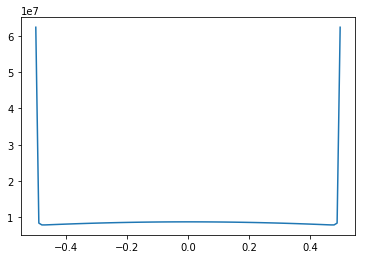

In [39]:
pp.plot(Earray,detarray)
#pp.axis([-delta,delta,-100000,100000])

In [30]:
[Earray[p] for p in range(len(Earray)) if np.sign(np.real(detarray[p]))<0]

[-0.47883838383838384, 0.47883838383838384]

In [40]:
[Earray[p] for p in range(len(Earray)) if np.sign(np.real(detarray[p]))<0]

[]

In [119]:
Barray=[3.]#np.ndarray.tolist(np.linspace(9,11,21))
NM=len(Barray)

L=50 #kx decimation
kxarray=np.linspace(-1.7,-1.4,L+1)
EJdisp=np.zeros([L+1,4*(NJ+2)])+1j*np.zeros([L+1,4*(NJ+2)])

SpecBvar=np.zeros((NM,np.shape(EJdisp)[0],np.shape(EJdisp)[1]))+1j*np.zeros((NM,np.shape(EJdisp)[0],np.shape(EJdisp)[1]))

for sb in range(NM):
    B=Barray[sb]
    print('{})B={}'.format(sb,B))
    for j in range(L+1):
        print(j)
        ekx=[]
        kx=kxarray[j]
        def fdet(En):
            print('fdet')
            return np.linalg.det(Gtotm1(En,kx))/(mu**(8*(NJ+2))) #here change between isolated junction and total system
        #jtmm=[-5+0.1*opq for opq in range(51)]
        x0roots=np.ndarray.tolist(np.linspace(delta-0.0001,0,np.int(delta/0.01)))
        #x0roots.extend(jtmm)
        for i in range(len(x0roots)):
            print(i)
            x0=x0roots[i]
            solekx=opt.fsolve(fdet,np.asarray(x0))
            if np.iscomplex(solekx):
                print('complex')
            if abs(fdet(solekx))>10**(-6) or abs(solekx)>delta or solekx<0:
                solekx=[]
            solekx=np.ndarray.tolist(np.around(solekx,3))
            ekx.extend(solekx)
        ekx=list(set(ekx))
        print(ekx)
        if len(ekx)<4*(NJ+2):
            zerocompletion=[delta]*(4*(NJ+2)-len(ekx))
            ekx.extend(zerocompletion)
        elif len(ekx)>4*(NJ+2):
            print("Too many roots.")
            break
        EJdisp[j]=np.asarray(ekx)
    SpecBvar[sb]=EJdisp

0)B=3.0
0
0
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
1
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
2
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
3
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
4
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
5
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
6
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
7
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet

fdet
fdet
fdet
13
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
14
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
15
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
16
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
17
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
18
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fd

fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
21
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
22
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
23
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
24
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
25
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
26
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fd

fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
40
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
41
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
42
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
43
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
44
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
45
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fd

fdet
fdet
19
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
20
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
21
fdet
fdet
fdet
fdet
fdet
fdet
fdet
22
fdet
fdet
fdet
fdet
fdet
fdet
fdet
23
fdet
fdet
fdet
fdet
fdet
fdet
fdet
24
fdet
fdet
fdet
fdet
fdet
fdet
fdet
25
fdet
fdet
fdet
fdet
fdet
fdet
fdet
26
fdet
fdet
fdet
fdet
fdet
fdet
fdet
27
fdet
fdet
fdet
fdet
fdet
fdet
fdet
28
fdet
fdet
fdet
fdet
fdet
fdet
fdet
29
fdet
fdet
fdet
fdet
fdet
fdet
fdet
30
fdet
fdet
fdet
fdet
fdet
fdet
fdet
31
fdet
fdet
fdet
fdet
fdet
fdet
fdet
32
fdet
fdet
fdet
fdet
fdet
fdet
fdet
33
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
34
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
35
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
36
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
f

13
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
14
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
15
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
16
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
17
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
18
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
19
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
20
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
21
fdet
fdet
fdet
fdet
fdet
fdet
fdet
22
fdet
fdet
fdet
fdet
fdet
fdet
fdet
23
fdet
fdet
fdet
fdet
fdet
fdet
fdet
24
fdet
fdet
fdet
fdet
fdet

fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
10
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
11
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
12
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
13
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
14
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
15
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
16
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
17
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
18
fdet
fdet
fdet
fdet
fdet
fdet
fde

fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
8
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
9
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
10
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
11
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
12
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
13
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
14
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
15
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fde

fdet
fdet
3
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
4
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
5
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
6
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
7
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
8
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fde

fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
23
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
24
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
25
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
26
fdet
fdet
fdet
fdet
fdet
fdet
fdet
27
fdet
fdet
fdet
fdet
fdet
fdet
fdet
28
fdet
fdet
fdet
fdet
fdet
fdet
fdet
29
fdet
fdet
fdet
fdet
fdet
fdet
fdet
30
fdet
fdet
fdet
fdet
fdet
fdet
fdet
31
fdet
fdet
fdet
fdet
fdet
fdet
fdet
32
fdet
fdet
fdet
fdet
fdet
fdet
fdet
33
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
34
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
35
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
36
fdet
fdet
fdet
fdet
fde

fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
41
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
42
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
43
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
44
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
45
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
46
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fd

fdet
fdet
fdet
fdet
fdet
fdet
5
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
6
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
7
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
8
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
9
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
10
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
11
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
12
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
f

fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
21
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
22
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
23
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
24
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
25
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
26
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
27
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
28
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
29
fdet
fdet
fdet
fdet
fdet
fdet
fdet
30
fdet


fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
43
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
44
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
45
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
46
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
47
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
48
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fd

fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
9
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
10
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
11
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
12
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
13
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
f

fdet
fdet
fdet
25
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
26
fdet
fdet
fdet
fdet
fdet
fdet
fdet
27
fdet
fdet
fdet
fdet
fdet
fdet
fdet
28
fdet
fdet
fdet
fdet
fdet
fdet
fdet
29
fdet
fdet
fdet
fdet
fdet
fdet
fdet
30
fdet
fdet
fdet
fdet
fdet
fdet
fdet
31
fdet
fdet
fdet
fdet
fdet
fdet
fdet
32
fdet
fdet
fdet
fdet
fdet
fdet
fdet
33
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
34
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
35
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
36
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
37
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
38
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
39
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet
fdet


KeyboardInterrupt: 

/usr/local/lib64/python2.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[-3.14, 0, -0.0, 0.55]

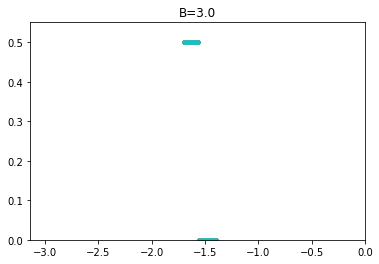

In [121]:
for sb in range(NM):
    EJdisp=SpecBvar[sb]
    pp.figure()
    pp.title("B={}".format(Barray[sb]))
    for p in range(len(EJdisp[1])):
        pp.plot(kxarray,EJdisp[:,p],'.')
pp.axis([-3.14,0,-0.,+0.55])

In [120]:
SpecBvar[sb]=EJdisp

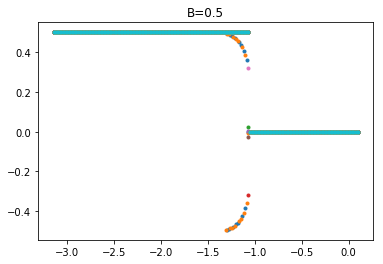

In [10]:
for sb in range(NM):
    EJdisp=SpecBvar[sb]
    pp.figure()
    pp.title("B={}".format(Barray[sb]))
    for p in range(len(EJdisp[1])):
        pp.plot(kxarray,EJdisp[:,p],'.')
#pp.axis([-1.5,-1,-0.1,+0.1])

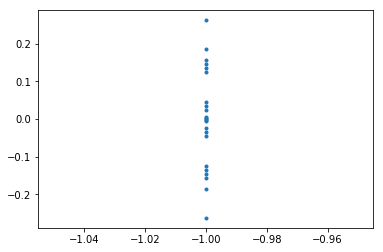

In [11]:
jpp=[0.0, 0.136, -0.035, 0.146, 0.126, -0.025, 0.005, -0.157, -0.263, -0.002, -0.187, -0.045,\
     -0.136, 0.045, 0.187, 0.002, 0.263, 0.157, -0.005, 0.025, -0.126, -0.146, 0.035]
pp.plot([-1]*len(jpp),jpp,'.')

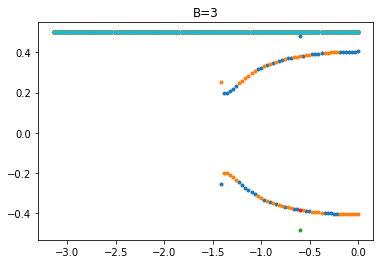

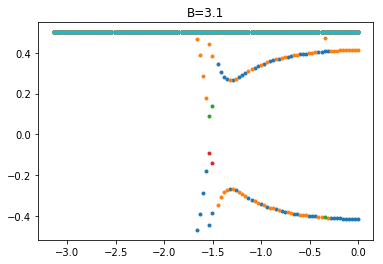

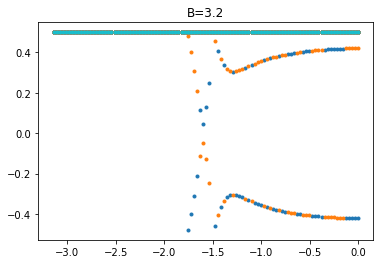

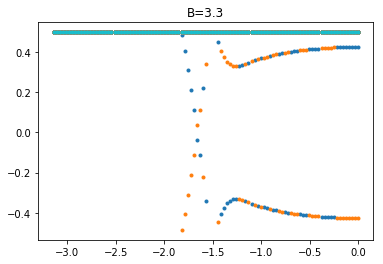

In [75]:
for sb in range(NM):
    EJdisp=SpecBvar[sb]
    pp.figure()
    pp.title("B={}".format(Barray[sb]))
    for p in range(len(EJdisp[1])):
        pp.plot(kxarray,EJdisp[:,p],'.')
#pp.axis([-np.real(kF+m*alR),np.real(kF+m*alR),-delta-0.1,delta+0.1])

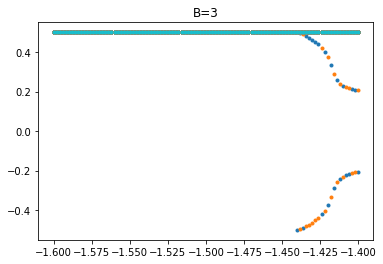

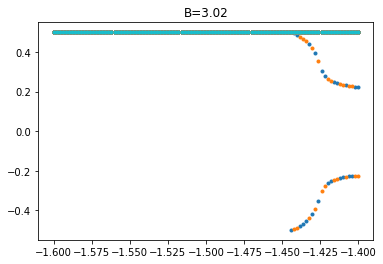

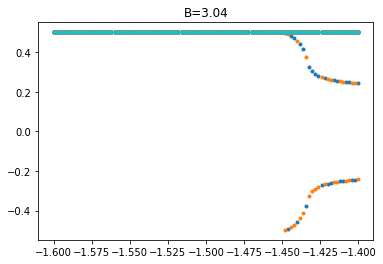

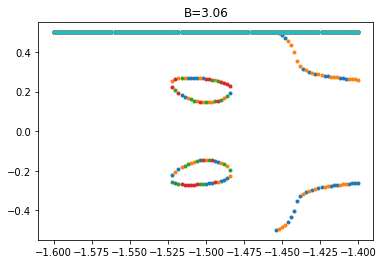

In [79]:
for sb in range(NM):
    EJdisp=SpecBvar[sb]
    pp.figure()
    pp.title("B={}".format(Barray[sb]))
    for p in range(len(EJdisp[1])):
        pp.plot(kxarray,EJdisp[:,p],'.')
#pp.axis([-np.real(kF+m*alR),np.real(kF+m*alR),-delta-0.1,delta+0.1])

Text(0.5,1,'B=3.055')

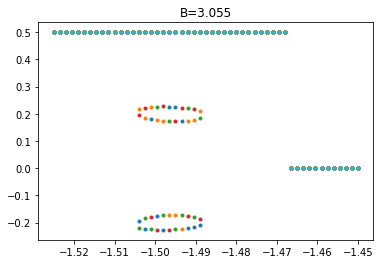

In [92]:
for p in range(len(EJdisp[1])):
    pp.plot(kxarray,EJdisp[:,p],'.')
#pp.axis([-np.real(kF+m*alR),np.real(kF+m*alR),-delta-0.1,delta+0.1])
pp.title('B=3.055')

Text(0.5,1,'B=3.08')

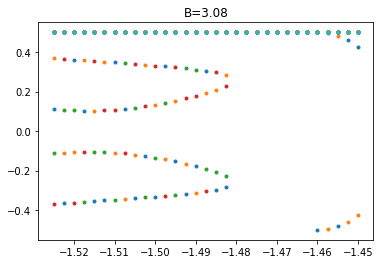

In [94]:
for p in range(len(EJdisp[1])):
    pp.plot(kxarray,EJdisp[:,p],'.')
#pp.axis([-np.real(kF+m*alR),np.real(kF+m*alR),-delta-0.1,delta+0.1])
pp.title('B=3.08')

Text(0.5,1,'B=3.1')

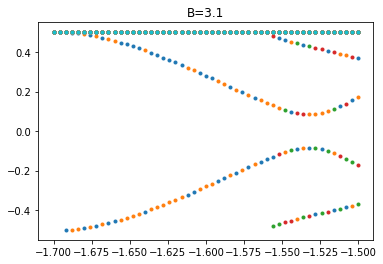

In [96]:
for p in range(len(EJdisp[1])):
    pp.plot(kxarray,EJdisp[:,p],'.')
#pp.axis([-np.real(kF+m*alR),np.real(kF+m*alR),-delta-0.1,delta+0.1])
pp.title('B=3.1')

Text(0.5,1,'B=3.07')

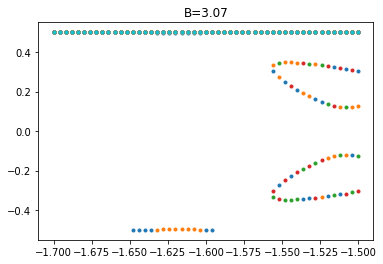

In [99]:
for p in range(len(EJdisp[1])):
    pp.plot(kxarray,EJdisp[:,p],'.')
#pp.axis([-np.real(kF+m*alR),np.real(kF+m*alR),-delta-0.1,delta+0.1])
pp.title('B=3.07')

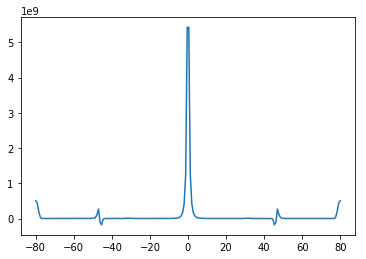

In [122]:
kx=kxarray[3]
xarray=np.linspace(-80,80,200)
yarray=np.array([fdet(xarray[l]) for l in range(len(xarray))])
pp.plot(xarray,yarray)
#pp.axis([-80,-50,-10**12,10**12])

In [84]:
mu**(8*NJ)

152587890625

In [133]:
np.sqrt(5)

2.23606797749979